#### Name: Ananya Godse SAPID: 60009220161

## Random Forest Classifier - Breast Cancer Dataset

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

### Loading and pre-processing the dataset

In [2]:
df = pd.read_csv("breast_cancer.csv")
df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [3]:
df.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

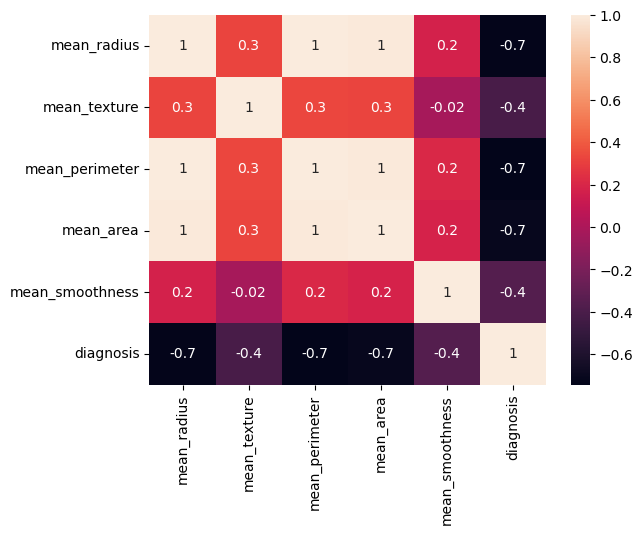

In [4]:
sns.heatmap(df.corr(), annot=True, fmt='0.1g')
plt.show()

In [5]:
df.drop(['mean_perimeter', 'mean_area'], axis=1, inplace=True)
df

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


In [6]:
df["cmean_radius"] = pd.cut(df["mean_radius"].values, bins = 3, labels = [0,1,2])
df["cmean_texture"] = pd.cut(df["mean_texture"].values, bins = 3, labels = [0,1,2])
df["cmean_smoothness"] = pd.cut(df["mean_smoothness"].values, bins = 3, labels = [0,1,2])
df = df.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
df = df[["cmean_radius", "cmean_texture", "cmean_smoothness","diagnosis"]]
df.head()


,cmean_radius,cmean_texture,cmean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0


### Calculating the entropy

This function calculates the entropy of the entire dataset, that is, the sum of probability of 'Yes' multiplied by log to the base 2 (probability of 'Yes') and the probability of 'No' multiplied by log to the base 2 (probability of 'No')

In [7]:
def entropy(df):
    class_col = df.keys()[-1]
    class_labels = df[class_col].unique()
    entropy = 0
    for label in class_labels:
        p = df[class_col].value_counts()[label]/len(df[class_col])
        entropy += -p * np.log2(p)
        
    return entropy

In [8]:
print(f"Entropy of the dataset: {entropy(df)}")

Entropy of the dataset: 0.9526351224018599


This function calculates the entropy of each attribute:

In [9]:
def attribute_entropy(df, attribute):
    class_col = df.keys()[-1]
    class_labels = df[class_col].unique()
    attribute_values = df[attribute].unique()
    attribute_entropy = 0
    for value in attribute_values:
        entropy = 0
        for label in class_labels:
            num = len(df[attribute][df[attribute]==value][df[class_col]==label])
            den = len(df[attribute][df[attribute]==value])
            p = num/den
            entropy += -p * np.log2(p + 0.000001)
        attribute_entropy += (den/len(df[attribute])) * entropy
    
    return attribute_entropy

As an example

In [10]:
print(f"Entropy of Mean Radius: {attribute_entropy(df, 'cmean_radius')}")

Entropy of Mean Radius: 0.5628857073951054


### Finding the best splitting attribute using Information Gain

This function calculates the information gain for each attribute and returns the attribute where the information gain is the largest. 

In [11]:
def information_gain(df):
    info_gain = []
    for attribute in df.keys()[:-1]:
        gain = entropy(df) - attribute_entropy(df, attribute)
        info_gain.append(gain)
    
    best_split = df.keys()[:-1][np.argmax(info_gain)]
    return best_split

In [12]:
print(f"Attribute with the greatest information gain: {information_gain(df)}")

Attribute with the greatest information gain: cmean_radius


### Building the tree

This function creates a subtable so that the tree can be grown from the current node. 

In [13]:
def sub_table(df, attribute, value):
    return df[df[attribute] == value].reset_index(drop = True)

This is the actual build tree function that is called recursively until we obtain a pure class at each leaf node. At every call, it filters the original dataset to return only rows that are useful for determining the next node.

In [14]:
def build_tree(df, tree=None, depth=0, max_depth=5):
    class_col = df.keys()[-1]
    node = information_gain(df)
    attribute_values = np.unique(df[node])

    if tree is None:
        tree = {}
        tree[node] = {}

    for value in attribute_values:
        subtable = sub_table(df, node, value)
        label, counts = np.unique(subtable[class_col], return_counts=True)
        
        if len(counts) == 1 or depth == max_depth:  
            tree[node][value] = label[0]
        else:
            tree[node][value] = build_tree(subtable, depth=depth+1)  
    
    return tree

### A single decision tree

In [15]:
tree = build_tree(df, max_depth=3)

In [16]:
pprint.pprint(tree)

{'cmean_radius': {0: {'cmean_smoothness': {0: {'cmean_texture': {0: 1,
                                                                 1: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}},
                                                                 2: 1}},
                                           1: {'cmean_texture': {0: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}},
                                                                 1: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}},
                                                                 2: 1}},
                                           2: {'cmean_texture': {0: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}},
                                                                 1: 0}}}},
                  1: {'cmean_texture': {0: {'cmean_smoothness': {0: {'cmean_radius': {1: {'cmean_radius': {1: {'cmean_radius': {1: 0}}}}}},
        

### Predicting the results of a single decision tree

In [17]:
def predict(test, tree):
    for node, subtree in tree.items():
        if node in test:
            value = test[node]
            if value in subtree:
                if isinstance(subtree[value], dict):
                    return predict(test, subtree[value])
                else:
                    return subtree[value]


In [18]:
input_data = {'cmean_radius': 1, 'cmean_texture': 0, 'cmean_smoothness': 1}
pred = predict(input_data,tree)
print(pred)

0


### Building a random forest

In [19]:
trees = []
def build_forest(n_estimators, df):
    for i in range(n_estimators):
        s_df = df.sample(frac=1/n_estimators, replace=True).reset_index(drop=True)
        trees.append(build_tree(s_df)) 
    return trees

In [20]:
forest = build_forest(12, df)

In [21]:
pprint.pprint(forest)

[{'cmean_radius': {0: {'cmean_texture': {0: 1,
                                         1: {'cmean_smoothness': {0: 1,
                                                                  1: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}},
                                                                  2: 0}}}},
                   1: {'cmean_texture': {0: {'cmean_smoothness': {0: 1,
                                                                  1: {'cmean_radius': {1: {'cmean_radius': {1: {'cmean_radius': {1: 0}}}}}}}},
                                         1: 0}}}},
 {'cmean_radius': {0: {'cmean_texture': {0: 1,
                                         1: {'cmean_smoothness': {0: 1,
                                                                  1: {'cmean_radius': {0: {'cmean_radius': {0: {'cmean_radius': {0: 0}}}}}}}},
                                         2: 1}},
                   1: {'cmean_texture': {0: {'cmean_smoothness': {0: 1,
               

### Predicting the results of a random forest

In [22]:
def predict_rf(input_data, trees):
    outputs = []
    for i in trees:
        outputs.append(predict(input_data, i))
    return max(set(outputs), key = outputs.count)


In [23]:
input_data = {'cmean_radius': 1, 'cmean_texture': 0, 'cmean_smoothness': 1}
predict_rf(input_data, forest)

0

### Accuracy

In [24]:
def calculate_accuracy(df, trees):
    correct_predictions = 0
    for index, row in df.iterrows():
        input_data = row.drop('diagnosis').to_dict()
        actual_class = row['diagnosis']
        
        prediction = predict_rf(input_data, trees)
        
        if prediction == actual_class:
            correct_predictions += 1
            
    accuracy = correct_predictions / len(df)
    return accuracy

In [25]:
accuracy = calculate_accuracy(df, trees)
print("Accuracy:", accuracy)

Accuracy: 0.8137082601054482
